In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
import os

base_dir = os.getcwd()
file_path = os.path.join( "..", "Data", "WA_Fn-UseC_-HR-Employee-Attrition.xls")

df = pd.read_csv(file_path)

In [5]:
print(df.head())

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [6]:
df = pd.read_csv(file_path)

cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df.drop(cols_to_drop, axis=1, inplace=True)

engagement_features = ['JobSatisfaction',
                    'EnvironmentSatisfaction',
                    'RelationshipSatisfaction',
                    'JobInvolvement',
                    'WorkLifeBalance']

In [ ]:

df['EngagementScore'] = df[engagement_features].mean(axis=1)

df['IncomePerYear'] = df['MonthlyIncome'] / (df['TotalWorkingYears'] + 1)  # +1 عشان ميقسمش على صفر

df['YearsAtCompany_vs_Level'] = df['YearsAtCompany'] / (df['JobLevel'] + 1)

df['Promotions'] = df['YearsAtCompany'] - df['YearsInCurrentRole'] - df['YearsSinceLastPromotion']
df['PromotionRate'] = np.where(df['YearsAtCompany'] > 0, df['YearsAtCompany'] / (df['YearsAtCompany'] + 1), 0)


df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [8]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

le = LabelEncoder()
for col in cat_cols:
    df[col + '_enc'] = le.fit_transform(df[col])
    
features_for_clustering = [
    'Age',
    'MonthlyIncome', 
    'JobLevel',
    'YearsAtCompany',
    'TotalWorkingYears',
    'PromotionRate',           
    'Department_enc',
    'JobRole_enc', 
    'JobInvolvement',
    'StockOptionLevel'
]
df_clust = df[features_for_clustering].copy()    

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_clust_scaled = pd.DataFrame(scaler.fit_transform(df_clust), columns=df_clust.columns)

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df_clust_scaled)
df_clean = df_clust_scaled[outliers == 1].reset_index(drop=True)

In [10]:
df_clean.to_csv("../Data/IBM_Engagement_Clustering_Ready.csv", index=False)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

df_ready = pd.read_csv('../Data/IBM_Engagement_Clustering_Ready.csv')

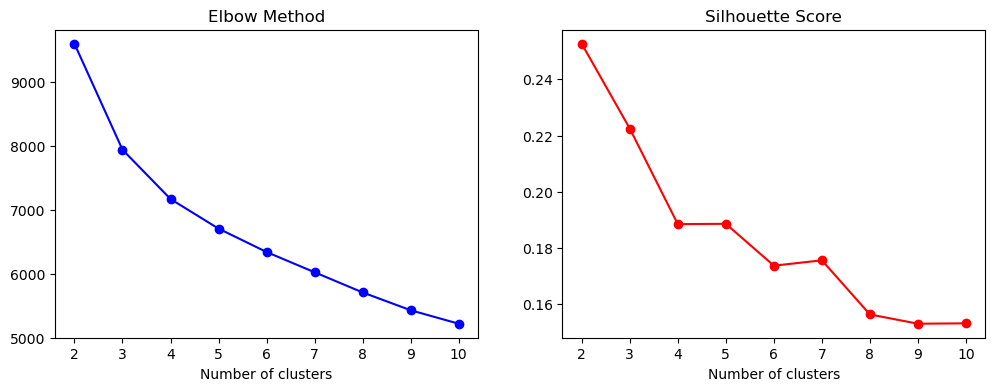

In [ ]:

inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_ready)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_ready, kmeans.labels_))


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.show()

In [ ]:

final_k = 4
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_ready)

df_ready['Cluster'] = clusters


profile = df_ready.groupby('Cluster').mean()
profile['Count'] = df_ready['Cluster'].value_counts()

print("\nEmployee Engagement Clusters Profile:")
print(profile.round(2).T)


cluster_names = {
    0: "Highly Engaged & Loyal",
    1: "Actively Disengaged",
    2: "Moderately Engaged",
    3: "New & Enthusiastic"
}

df_ready['Cluster_Name'] = df_ready['Cluster'].map(cluster_names)
print("\nأسماء الكلاسترات:")
print(df_ready['Cluster_Name'].value_counts())


Employee Engagement Clusters Profile:
Cluster                 0       1       2       3
Age                  1.05   -0.63   -0.20    0.12
MonthlyIncome        1.80   -0.72   -0.14   -0.23
JobLevel             1.68   -0.83   -0.05   -0.16
YearsAtCompany       0.87   -0.66   -0.14    0.12
TotalWorkingYears    1.60   -0.75   -0.28   -0.02
PromotionRate        0.50   -0.65    0.09    0.40
Department_enc      -0.15   -0.55    1.40   -0.63
JobRole_enc         -0.28   -0.13    1.10   -0.65
JobInvolvement      -0.07   -0.23   -0.02    0.26
StockOptionLevel    -0.13   -0.12   -0.01    0.12
Count              189.00  385.00  372.00  450.00

أسماء الكلاسترات:
Cluster_Name
New & Enthusiastic        450
Actively Disengaged       385
Moderately Engaged        372
Highly Engaged & Loyal    189
Name: count, dtype: int64


In [14]:
!pip install joblib

In [ ]:
import joblib

joblib.dump(kmeans, '../Models/employee_engagement_clustering.pkl')


joblib.dump(scaler, '../Scalers/employee_engagement_scaler.pkl')

print("✅ Model and scaler saved successfully!")
print(f"   - Model: employee_engagement_clustering.pkl")
print(f"   - Scaler: employee_engagement_scaler.pkl")

✅ Model and scaler saved successfully!
   - Model: employee_engagement_clustering.pkl
   - Scaler: employee_engagement_scaler.pkl
